In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 7.6 MB/s 
     |████████████████████████████████| 596 kB 81.5 MB/s 
     |████████████████████████████████| 895 kB 85.5 MB/s 
     |████████████████████████████████| 6.6 MB 50.3 MB/s 
     |████████████████████████████████| 77 kB 5.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install watermark

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [4]:
!pip install --upgrade torch==1.4.0

     |████████████████████████████████| 753.4 MB 6.4 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.1
    Uninstalling torch-1.10.1:
      Successfully uninstalled torch-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.


In [5]:
!pip install --upgrade transformers==2.8.0

     |████████████████████████████████| 563 kB 5.0 MB/s 
     |████████████████████████████████| 5.6 MB 24.1 MB/s 
     |████████████████████████████████| 1.2 MB 40.6 MB/s 
     |████████████████████████████████| 895 kB 39.2 MB/s 
     |████████████████████████████████| 132 kB 34.4 MB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 8.7 MB 46.5 MB/s 
     |████████████████████████████████| 138 kB 35.3 MB/s 
     |████████████████████████████████| 127 kB 44.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.4.0
transformers: 2.8.0



In [2]:
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np

import logging
logging.basicConfig(level=logging.INFO) 

import matplotlib.pyplot as plt
% matplotlib inline

import os
from tqdm.notebook import tqdm

import random
from sklearn import metrics, model_selection, preprocessing
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim


In [3]:
os.chdir('drive/MyDrive/William_2022')

In [4]:
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

In [5]:
df = pd.read_csv('DATASETS/CSV/full_transcript_concat.csv')

In [7]:
df['arousal_trans'] = df['arousal_trans'].round()
df['arousal2_trans'] = df['arousal2_trans'].round()

df['valence_trans'] = df['valence_trans'].round()
df['valence2_trans'] = df['valence2_trans'].round()

df['happy_trans'] = df['happy_trans'].round()
df['happy2_trans'] = df['happy2_trans'].round()

df['angry_trans'] = df['angry_trans'].round()
df['angry2_trans'] = df['angry2_trans'].round()

df['nervous_trans'] = df['nervous_trans'].round()
df['nervous2_trans'] = df['nervous2_trans'].round()

df['sad_trans'] = df['sad_trans'].round()
df['sad2_trans'] = df['sad2_trans'].round()

First Participant

In [8]:
df1_happy = df[['new_words', 'happy_trans']]

In [9]:
df1_happy['happy_trans'] = df1_happy['happy_trans'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df1_happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863 entries, 0 to 1862
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   new_words    1863 non-null   object
 1   happy_trans  1863 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 29.2+ KB


In [36]:
df1_happy['happy_trans'].unique()

array([2, 1, 3])

In [10]:
def to_emotion(rating):
  rating = int(rating)
  if rating == 2:
    return 1
  elif rating == 3:
    return 2
  else: 
    return 0

df1_happy['happy_trans'] = df.happy_trans.apply(to_emotion)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [11]:
df1_happy['happy_trans'].unique()

array([1, 0, 2])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'happy rating')

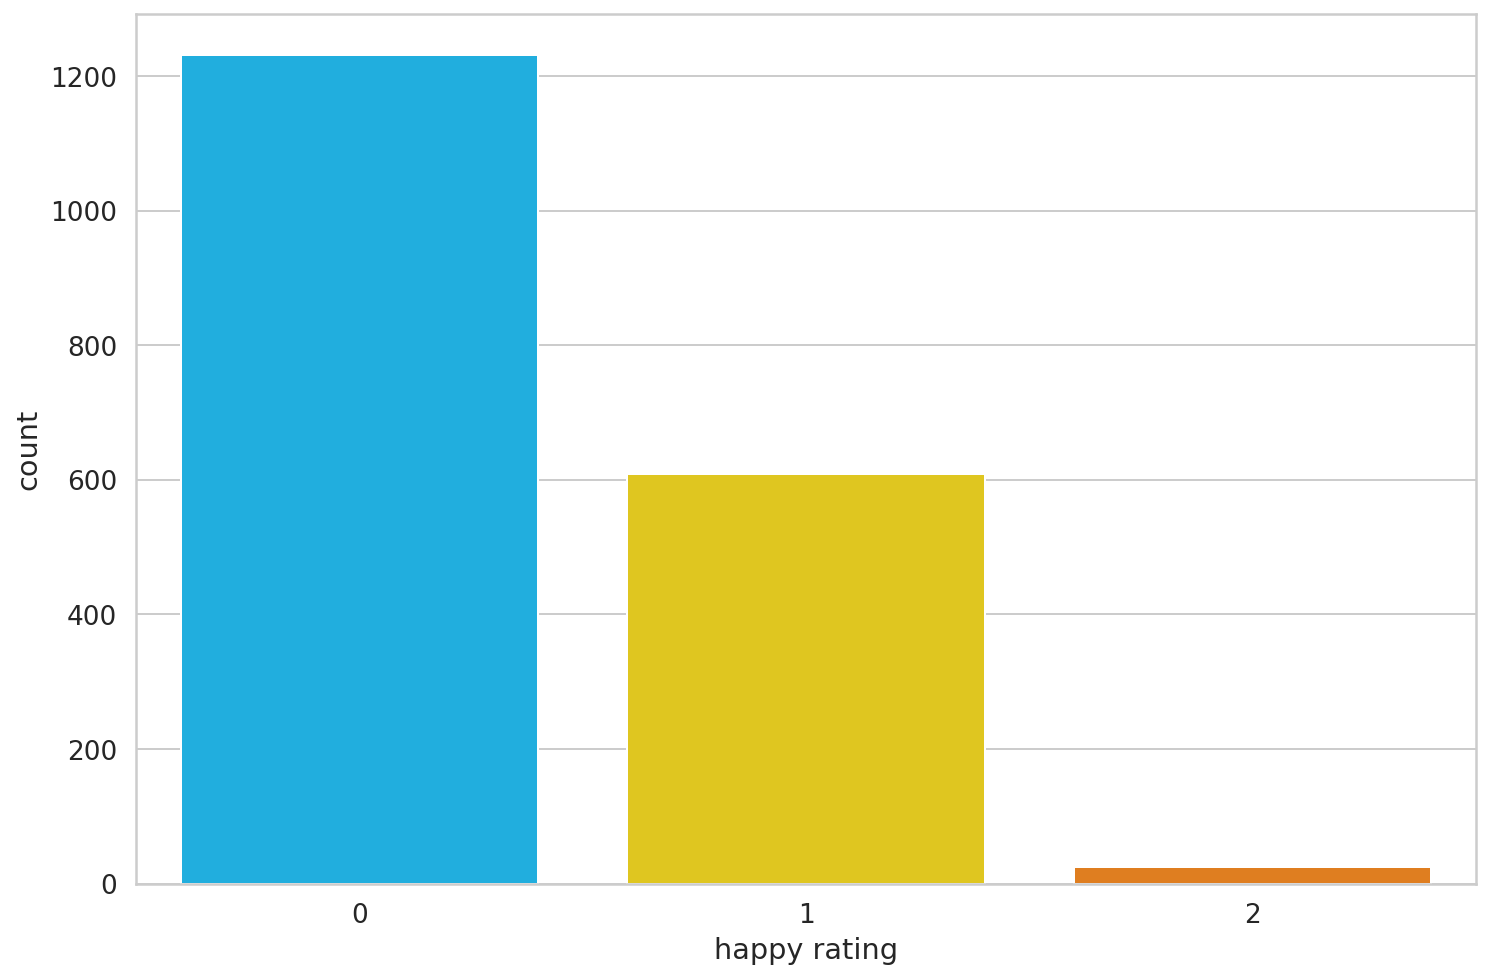

In [11]:
sns.countplot(df1_happy.happy_trans)
plt.xlabel('happy rating')

In [ ]:
'''
0 == very low
1 == low
2 == high
'''

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp6_n5ojcr


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt in cache at /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1


In [13]:
token_lens = []
for txt in df1_happy.new_words:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


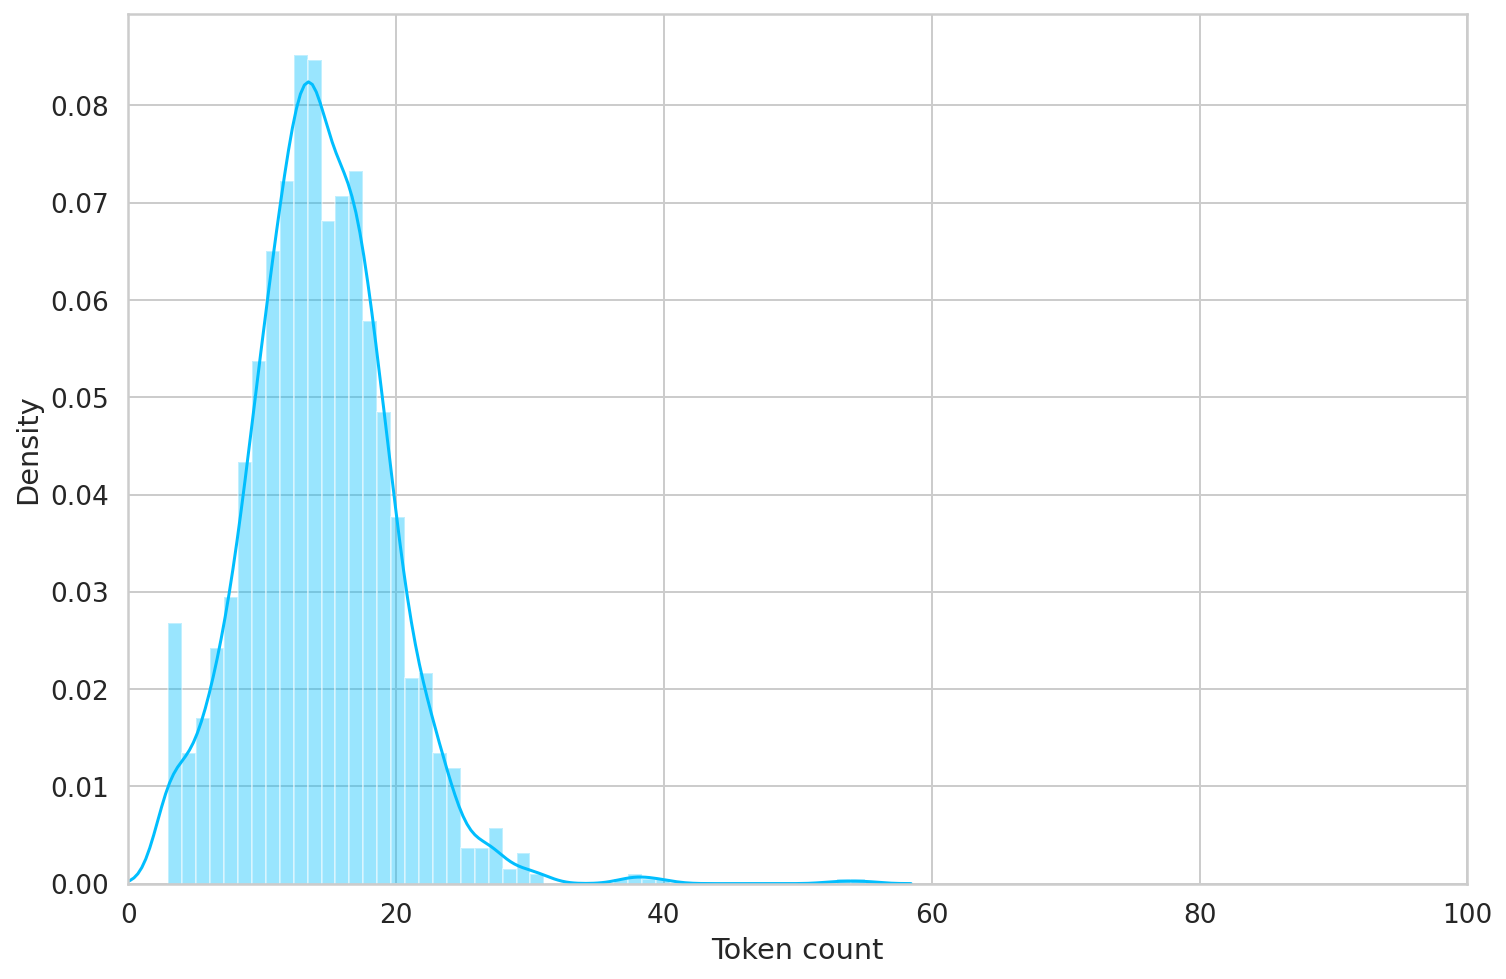

In [14]:
sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [15]:
MAX_LEN = 80

class HappyDataset(Dataset):
  def __init__(self, texts, targets, tokenizer, max_len):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, item):
    text = str(self.texts[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'transcript_texts': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [16]:
df_train, df_test = train_test_split(
  df1_happy,
  test_size=0.2,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [17]:
print(df_train.shape, df_val.shape, df_test.shape)

(1490, 2) (186, 2) (187, 2)


In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = HappyDataset(
    texts=df1_happy.new_words.to_numpy(),
    targets=df1_happy.happy_trans.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [19]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['transcript_texts', 'input_ids', 'attention_mask', 'targets'])

In [21]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)


torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [23]:
class EmotionClassifier(nn.Module):
  def __init__(self, n_classes):
    super(EmotionClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    returned = self.bert(
    input_ids=input_ids,
    attention_mask=attention_mask
    )
    pooled_output = returned["pooler_output"]
    output = self.drop(pooled_output)
    return self.out(output)

In [30]:
class EmotionClassifier(nn.Module):
  def __init__(self, n_classes):
    super(EmotionClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [31]:
class_names = ['very low', 'low', 'high']

In [25]:
len(class_names)

3

In [32]:
model = EmotionClassifier(len(class_names))
model = model.to(device)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /root/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
INFO:transformers.configuration_utils:Model config BertConfig {
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1

In [ ]:
model

In [33]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 80])
torch.Size([16, 80])


In [34]:
F.softmax?

In [35]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1640, 0.3245, 0.5115],
        [0.1556, 0.5050, 0.3395],
        [0.1509, 0.3548, 0.4943],
        [0.2586, 0.4857, 0.2557],
        [0.1928, 0.3725, 0.4346],
        [0.2012, 0.3698, 0.4290],
        [0.1598, 0.5164, 0.3239],
        [0.1574, 0.4999, 0.3427],
        [0.2068, 0.4459, 0.3473],
        [0.1716, 0.5798, 0.2486],
        [0.1270, 0.3650, 0.5079],
        [0.2389, 0.3545, 0.4066],
        [0.1879, 0.4698, 0.3424],
        [0.1939, 0.4342, 0.3718],
        [0.1621, 0.3611, 0.4768],
        [0.1814, 0.4537, 0.3649]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [36]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [37]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [39]:
%%time

history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.3554546455414886 accuracy 0.7127516778523489
Val   loss 0.8982507622140086 accuracy 6.618279569892474

Epoch 2/10
----------
Train loss 1.0542327085366616 accuracy 0.7899328859060403
Val   loss 1.1638549454828613 accuracy 6.618279569892474

Epoch 3/10
----------
Train loss 1.2118624966177676 accuracy 0.8255033557046979
Val   loss 1.303044742721523 accuracy 6.618279569892474

Epoch 4/10
----------
Train loss 1.1896704280446482 accuracy 0.8261744966442952
Val   loss 1.2978727999183102 accuracy 6.618279569892474

Epoch 5/10
----------
Train loss 1.263781665927834 accuracy 0.8261744966442952
Val   loss 1.3316207686041155 accuracy 6.618279569892474

Epoch 6/10
----------
Train loss 1.2926895866313806 accuracy 0.8261744966442952
Val   loss 1.349689953809238 accuracy 6.618279569892474

Epoch 7/10
----------
Train loss 1.3092953544587662 accuracy 0.8261744966442952
Val   loss 1.3570986554727085 accuracy 6.618279569892474

Epoch 8/10
----------
Train loss 1.32

TypeError: ignored

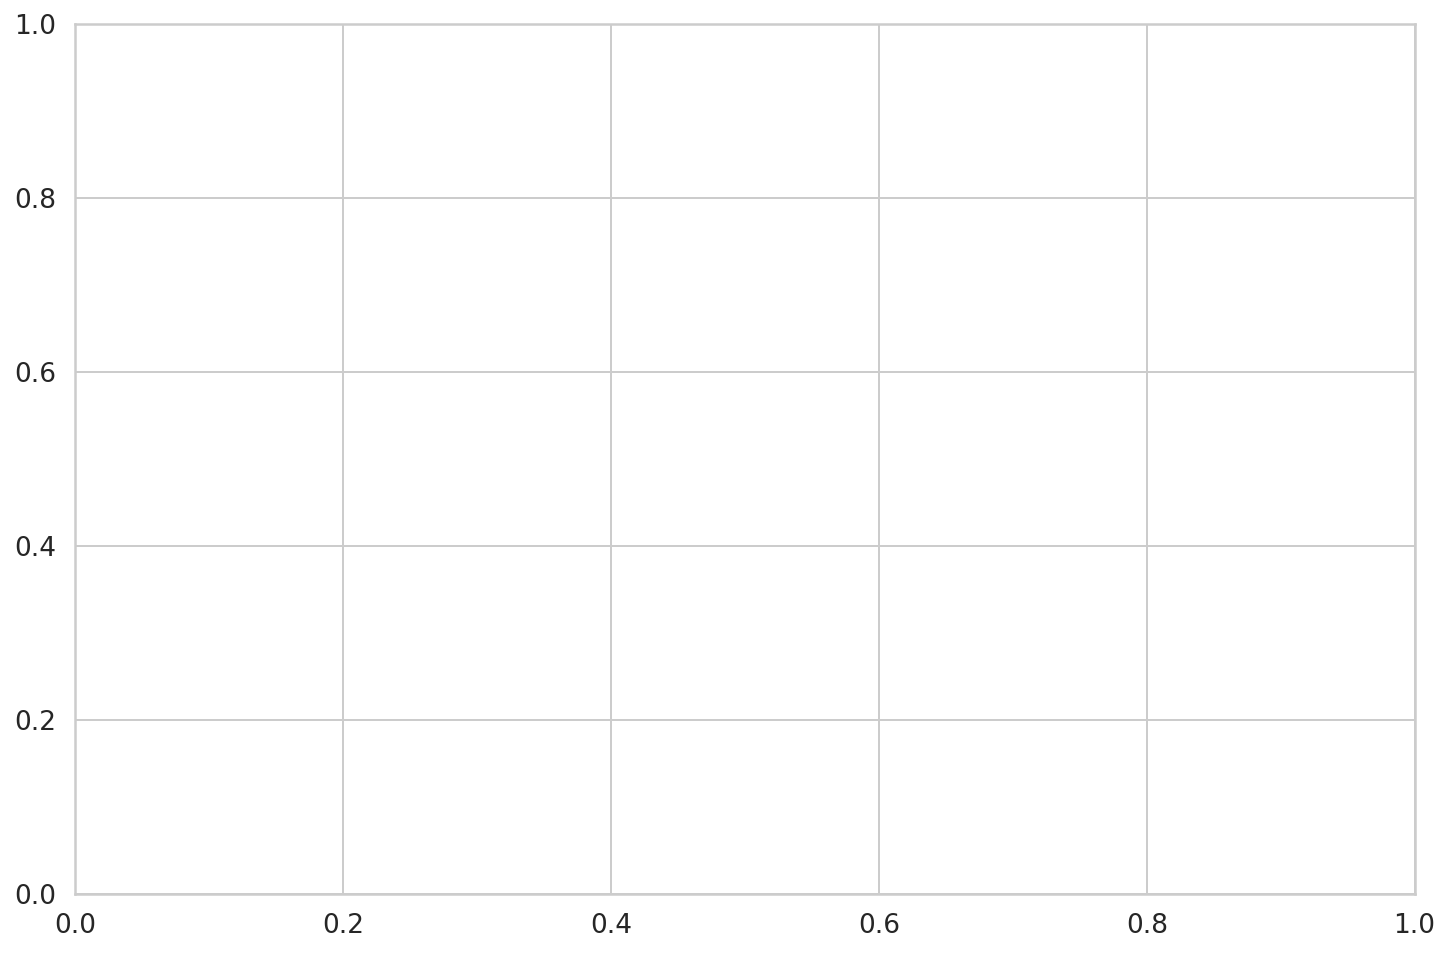

In [43]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Second Participant

In [ ]:
df2_happy = df[['new_words', 'happy2_trans']]